In [ ]:
## PART 1 - Fashion MNIST - PCA 

In [1]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

X_train = X_train / 255.0
X_test = X_test / 255.0


In [9]:
#Logistic Regression w/o PCA 
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=100, solver="saga", n_jobs=-1)
model.fit(X_train, y_train)


/Users/syonaa/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(n_jobs=-1, solver='saga')

In [11]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred)
print(f"Accuracy without PCA: {accuracy_original:.4f}")

Accuracy without PCA: 0.8440


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_scaled)

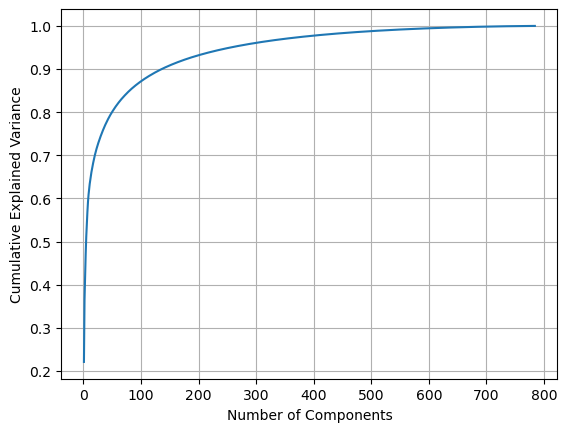

In [14]:
import numpy as np
import matplotlib.pyplot as plt

explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

In [15]:
n_components = 600 
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [16]:
model_pca = LogisticRegression(max_iter=100, solver="saga", n_jobs=-1)
model_pca.fit(X_train_pca, y_train)

/Users/syonaa/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(n_jobs=-1, solver='saga')

In [17]:
y_pred_pca = model_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy with PCA: {accuracy_pca:.4f}")


Accuracy with PCA: 0.8460


In [18]:
##Part 2 

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.metrics import accuracy_score


In [27]:
df = pd.read_csv("train.csv")


In [28]:
df

,uid,day,hour,minute,C_motion,feed_water_motion,faucet_hole,vapour_pressure,vapour_enthalpy,vapour_pressure_at_division,vapour_motion,feed_water_enth,vapour_temperature,output_electricity_generation
0,0,Saturday,7.0,NaN,387.374315,2681.205431,0.678352,25.050893,2775.784134,26.465138,2682.758692,1289.082351,601.850322,974.182544
1,1,Saturday,12.0,28.0,238.153011,1604.213100,0.679706,15.241147,2903.619864,NaN,1602.318002,1144.454102,603.933579,593.915516
2,2,Friday,15.0,13.0,338.270228,2398.561685,0.662971,23.078376,2796.443584,24.316160,NaN,1258.098883,602.443281,884.033450
3,3,Saturday,14.0,NaN,254.294492,1620.034059,0.679977,15.054982,2818.023511,15.895513,1619.387667,1142.463833,588.938717,584.908719
4,4,Saturday,18.0,16.0,203.189410,1485.672389,0.686342,12.963420,2816.144355,13.682371,1487.685052,1099.539481,504.208816,483.609973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50395,50395,Saturday,3.0,53.0,358.326096,2466.188446,0.679246,23.079785,2795.566204,24.382871,2463.927286,1263.867952,NaN,907.096390
50396,50396,Saturday,18.0,6.0,205.657731,1520.898592,0.683778,13.324238,2833.890795,14.059122,NaN,1107.134960,506.487329,497.459473
50397,50397,Friday,NaN,4.0,356.572958,2432.402583,0.678961,22.805262,2784.953650,24.089748,NaN,1258.890934,NaN,892.699691
50398,50398,Friday,17.0,23.0,344.533133,2447.181803,0.661900,23.493103,2803.209426,NaN,2445.952298,1264.949843,603.189838,897.466022


In [29]:
def encode_time_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
    return df.drop(columns=['hour', 'minute'])

df = encode_time_features(df)



In [30]:
df = pd.get_dummies(df, columns=['day'], drop_first=True)

In [31]:
imputer = SimpleImputer(strategy='median')
df.iloc[:, :] = imputer.fit_transform(df)

/var/folders/wv/6mym4l8x2m103zryzwg2jgzw0000gn/T/ipykernel_90108/2137833673.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, :] = imputer.fit_transform(df)


In [32]:
y = df['output_electricity_generation']
X = df.drop(columns=['output_electricity_generation', 'uid'])


In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [35]:
var_thresh = VarianceThreshold(threshold=0.01)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

In [67]:
corr_matrix = pd.DataFrame(X_train).corr()
high_corr_features = [col for col in corr_matrix.columns if any(abs(corr_matrix[col]) > 0.9)]

if len(high_corr_features) < X_train.shape[1]:  
    X_train_corr = np.delete(X_train, high_corr_features, axis=1)
    X_test_corr = np.delete(X_test, high_corr_features, axis=1)
else:
    X_train_corr, X_test_corr = X_train[:, :1], X_test[:, :1]  


In [37]:
anova_selector = SelectKBest(score_func=f_classif, k=10)
X_train_anova = anova_selector.fit_transform(X_train, y_train)
X_test_anova = anova_selector.transform(X_test)

In [40]:
from sklearn.feature_selection import mutual_info_regression
mi_selector = SelectKBest(score_func=mutual_info_regression, k=10)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
X_test_mi = mi_selector.transform(X_test)

In [45]:
from sklearn.linear_model import LinearRegression

rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select=10)
X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
X_test_rfe = rfe_selector.transform(X_test)


In [68]:
from sklearn.metrics import mean_squared_error

def evaluate_model(X_train, X_test, y_train, y_test):
    if X_train.shape[1] == 0:
        return float('inf') 
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [69]:
results = {
    "Variance Thresholding": evaluate_model(X_train_var, X_test_var, y_train, y_test),
    "Correlation Filtering": evaluate_model(X_train_corr, X_test_corr, y_train, y_test),
    "ANOVA Selection": evaluate_model(X_train_anova, X_test_anova, y_train, y_test),
    "Mutual Information": evaluate_model(X_train_mi, X_test_mi, y_train, y_test),
    "Recursive Feature Elimination": evaluate_model(X_train_rfe, X_test_rfe, y_train, y_test)
}



In [70]:
print("Feature Selection Method Evaluation:")
for method, score in results.items():
    print(f"{method}: {score:.4f}")


Feature Selection Method Evaluation:
Variance Thresholding: 1833.3196
Correlation Filtering: 14945.4763
ANOVA Selection: 2139.0806
Mutual Information: 2051.9606
Recursive Feature Elimination: 1856.5150


In [71]:
##Part 3 

In [104]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [105]:
from sklearn.datasets import load_iris
iris = load_iris()


In [106]:
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv"
df = pd.read_csv(url)

In [107]:
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [108]:
X = df.drop(columns=['species'])


In [109]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [113]:
print(df.columns)  


Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')


/Users/syonaa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/syonaa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/syonaa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/syonaa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/syonaa/an

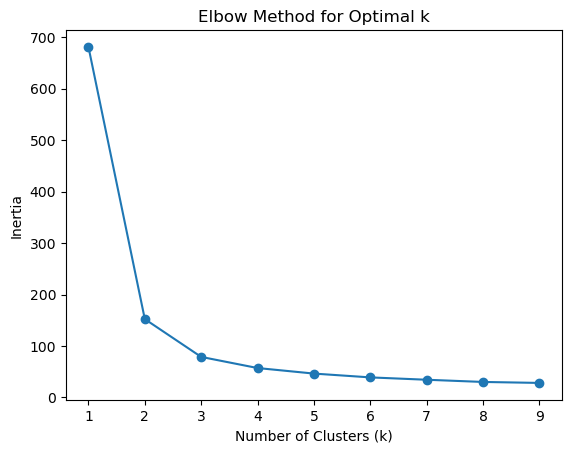

In [114]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()


In [115]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])

kmeans = KMeans(n_clusters=3, random_state=42)
df['predict'] = kmeans.fit_predict(df_scaled)


/Users/syonaa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


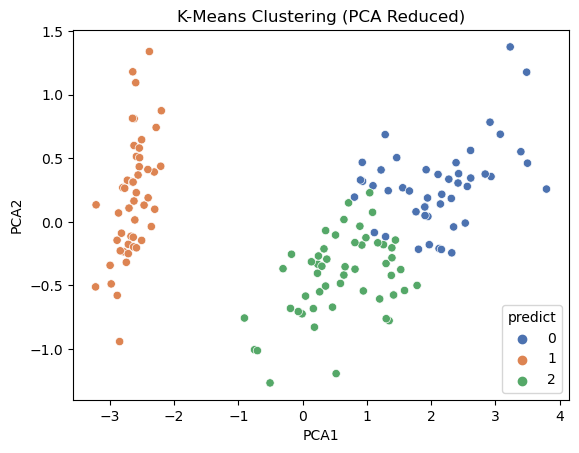

In [103]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']])
df['PCA1'], df['PCA2'] = df_pca[:, 0], df_pca[:, 1]

sns.scatterplot(x=df['PCA1'], y=df['PCA2'], hue=df['predict'], palette='deep')
plt.title("K-Means Clustering (PCA Reduced)")
plt.show()


In [116]:
print("Cluster Centers:")
print(kmeans.cluster_centers_)

Cluster Centers:
[[ 1.13597027  0.08842168  0.99615451  1.01752612]
 [-1.01457897  0.85326268 -1.30498732 -1.25489349]
 [-0.05021989 -0.88337647  0.34773781  0.2815273 ]]
